In [25]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy_gpu as ppy
import pandas as pd
from tqdm import tqdm
from seaborn.apionly import color_palette
%matplotlib inline

/n/home01/bcook/.conda/envs/py36/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
plt.style.use('cook')

In [3]:
from setup_files.mocks_paper1.mock_models import models as mock_models, run_names as mock_names, results as mock_res

In [4]:
from setup_files.m31_paper2.m31_models import models as m31_models, run_names as m31_names, results as m31_res

/n/home01/bcook/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/n/home01/bcook/pCMDs/pixcmd/pcmdpy/pcmdpy/plotting/results.py:83: RuntimeWarning: invalid value encountered in sqrt
  logzerrs.append(np.sqrt(logzvar))


In [5]:
models = mock_models.copy()
models.update(m31_models)

run_names = mock_names.copy()
run_names.update(m31_names)

results = mock_res.copy()
results.update(m31_res)

# Setup

In [14]:
f_mock = ppy.instrument.default_m31_filters()
f_summer = ppy.instrument.m31_summer_filters()
f_winter = ppy.instrument.m31_winter_filters()

In [15]:
iso_mock = ppy.isochrones.Isochrone_Model(f_mock, mag_system='vega')
iso_summer = ppy.isochrones.Isochrone_Model(f_summer, mag_system='ab')
iso_winter = ppy.isochrones.Isochrone_Model(f_winter, mag_system='ab')

In [16]:
driv_mock = ppy.driver.Driver(iso_mock)
driv_summer = ppy.driver.Driver(iso_summer)
driv_winter = ppy.driver.Driver(iso_winter)

Please wait while the GPU states are initializedPlease wait while the GPU states are initializedPlease wait while the GPU states are initialized

In [17]:
magbins = np.arange(10, 45, 0.05)
colorbins = np.arange(-1.5, 5.6, 0.05)  # fairly insensitive to distance
bins = [magbins, colorbins]

magbins_n = np.arange(10, 45, 0.02)
colorbins_n = np.arange(-1.5, 5.6, 0.02)  # fairly insensitive to distance
narrow_bins = [magbins_n, colorbins_n]

magbins_w = np.arange(10, 45, 0.1)
colorbins_w = np.arange(-1.5, 5.6, 0.1)  # fairly insensitive to distance
wide_bins = [magbins_w, colorbins_w]

In [18]:
logls = {}
logls_true = {}

In [19]:
N_sample = 10
for k, r in tqdm(results.items()):
    season = getattr(r, 'season', '')
    if 'summer' in season:
        driv = driv_summer
    elif 'winter' in season:
        driv = driv_winter
    else:
        driv = driv_mock
    Nim_mock = 256
    Nim = 512
    if k == 'mock_10':
        Nim = 256
    if k == 'mock_11':
        Nim = 1024
    like_mode = 2
    if k == 'mock_9':
        like_mode = 3
    these_bins = bins
    if k in ['mock_29', 'mock_31']:
        these_bins = wide_bins
    elif k in ['mock_30', 'mock_32']:
        these_bins = narrow_bins
    logl = []
    logl_true = []
    pcmd_orig = driv.simulate(r.best_model, Nim_mock, fixed_seed=True)[0]
    if r.true_model is not None:
        pcmd_true = driv.simulate(r.true_model, Nim_mock, fixed_seed=True)[0]
    for _ in range(N_sample):
        pcmd_new = driv.simulate(r.best_model, Nim)[0]
        driv.initialize_data(pcmd_orig, bins=these_bins)
        logl.append(driv.loglike(pcmd_new, like_mode=like_mode))
        if r.true_model is not None:
            driv.initialize_data(pcmd_true, bins=these_bins)
            logl_true.append(driv.loglike(pcmd_new, like_mode=like_mode))
    logls[k] = logl
    logls_true[k] = logl_true
print(logls)
print(logls_true)

100%|██████████| 113/113 [30:10<00:00, 14.17s/it]

{'mock_1': [-976.6845934232705, -974.9893324553609, -982.635149818578, -955.423698725402, -944.7073576187066, -1041.2052604801834, -965.1047727623708, -933.0805774207248, -1064.8956726242568, -995.2528411710238], 'mock_2': [-54.9586810372387, -51.426091668442716, -49.10961556658081, -56.83432749262859, -39.44599202081484, -56.41754203597271, -36.98651713049494, -39.80809102255135, -84.19946442262182, -66.88679171554743], 'mock_3': [-913.0256970313129, -933.8324296035795, -944.473894319146, -942.8295544726664, -900.9053726892105, -933.3787731630903, -929.3801960301647, -969.1557661410097, -911.0296120325363, -938.1187489686814], 'mock_4': [-36.284504153546045, -50.38538087027593, -43.74919094949897, -63.08656063284434, -42.31779254398099, -44.14554997222106, -49.99017922371268, -51.60648687740158, -32.5657027402708, -51.35887932642953], 'mock_5': [-983.418987615571, -923.8045502959395, -947.8372377635293, -954.0863836622626, -982.7855835313504, -958.437988010456, -967.0963364109995, -96

In [20]:
logl_means = {k: np.mean(v) for k,v in logls.items()}
logl_true_means = {k: np.mean(v) for k,v in logls_true.items()}

/n/home01/bcook/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/n/home01/bcook/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
df_logl = pd.DataFrame.from_dict(logl_means, 'index', columns=['logl_mean'])
df_true = pd.DataFrame.from_dict(logl_true_means, 'index', columns=['logl_true'])
df_logl = df_logl.merge(df_true, how='outer', left_index=True, right_index=True)
df_logl.head()

,logl_mean,logl_true
mock_1,-983.397926,-1057.917191
mock_2,-53.607311,-73.388491
mock_3,-931.613004,-953.908292
mock_4,-46.549023,-424.865692
mock_5,-962.418095,-1009.488393


In [29]:
(df_logl.logl_mean - df_logl.logl_true) / df_logl.logl_true

mock_1    -0.070440
mock_2    -0.269541
mock_3    -0.023373
mock_4    -0.890438
mock_5    -0.046628
mock_6    -0.069465
mock_7    -0.222606
mock_8    -0.197126
mock_9     0.000027
mock_10   -0.011293
mock_11   -0.125202
mock_12   -0.953748
mock_13   -0.932438
mock_14   -0.558961
mock_15   -0.969373
mock_16   -0.976717
mock_17   -0.992505
mock_18   -0.007024
mock_19   -0.061861
mock_20   -0.031829
mock_21   -0.056490
mock_22   -0.029156
mock_23   -0.005770
mock_24    0.012029
mock_25    0.003445
mock_26   -0.246909
mock_27   -0.414514
mock_28    0.188625
mock_29    0.058441
mock_30   -0.028285
             ...   
d5-m2           NaN
d6-m2           NaN
d7-m2           NaN
d8-m2           NaN
d9-m2           NaN
d10-m2          NaN
b1-m3           NaN
b2-m3           NaN
b3-m3           NaN
b4-m3           NaN
b5-m3           NaN
b6-m3           NaN
b7-m3           NaN
b8-m3           NaN
b9-m3           NaN
d1-m3           NaN
d4-m3           NaN
d5-m3           NaN
b1-m4           NaN


In [22]:
df_mock = df_logl[~np.in1d(df_logl.index.values, list(m31_res.keys()))]
df_m31 = df_logl[np.in1d(df_logl.index.values, list(m31_res.keys()))]
df_m31.drop('logl_true', axis=1, inplace=True)

/n/home01/bcook/.conda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
df_mock.to_csv('setup_files/mocks_paper1/max_logls.csv', float_format='%.3f', index_label='run_name')

In [24]:
df_m31.to_csv('setup_files/m31_paper2/max_logls.csv', float_format='%.3f', index_label='run_name')

In [108]:
r = results['mock_5']

In [133]:
1.0 - np.exp(-0.5 * (1))

0.3934693402873666

In [123]:
from seaborn.apionly import color_palette

In [131]:
colors = color_palette('colorblind', n_colors=10).as_hex()

/n/home01/bcook/dynesty/dynesty/utils.py:679: RuntimeWarning: invalid value encountered in sqrt
  new_res.logzerr = np.sqrt(np.array(saved_logzvar))


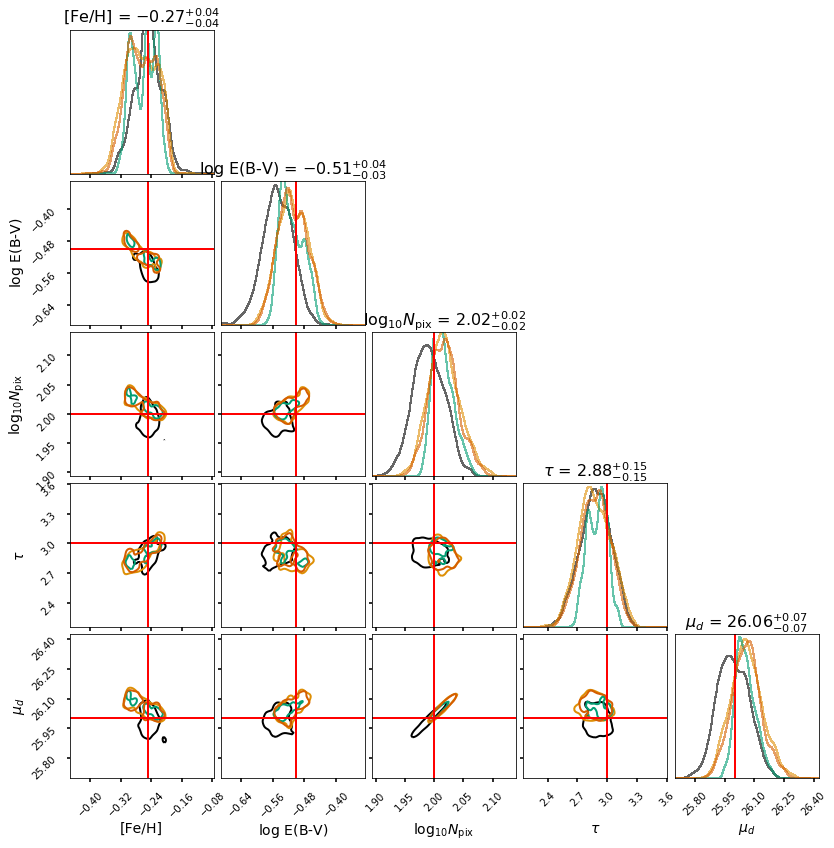

In [134]:
r = results['mock_5']
kwargs = {
    'hist_kwargs': {'histtype': 'step'},
    'quantiles': [],
    'hist2d_kwargs': {'fill_contours': False,
                     'plot_density': False,
                     'levels': [0.3934693402873666]},
    'sig_levels':
}
c = colors[0]
fig = r.plot_corner(max_logl=df_mock.loc['mock_5'].logl_mean, **kwargs)

for i, k in enumerate(['mock_18', 'mock_19', 'mock_20']):
    r = results[k]
    r.plot_corner(max_logl=df_mock.loc[k].logl_mean, fig=fig, color=colors[i+1], **kwargs);

/n/home01/bcook/dynesty/dynesty/utils.py:679: RuntimeWarning: invalid value encountered in sqrt
  new_res.logzerr = np.sqrt(np.array(saved_logzvar))


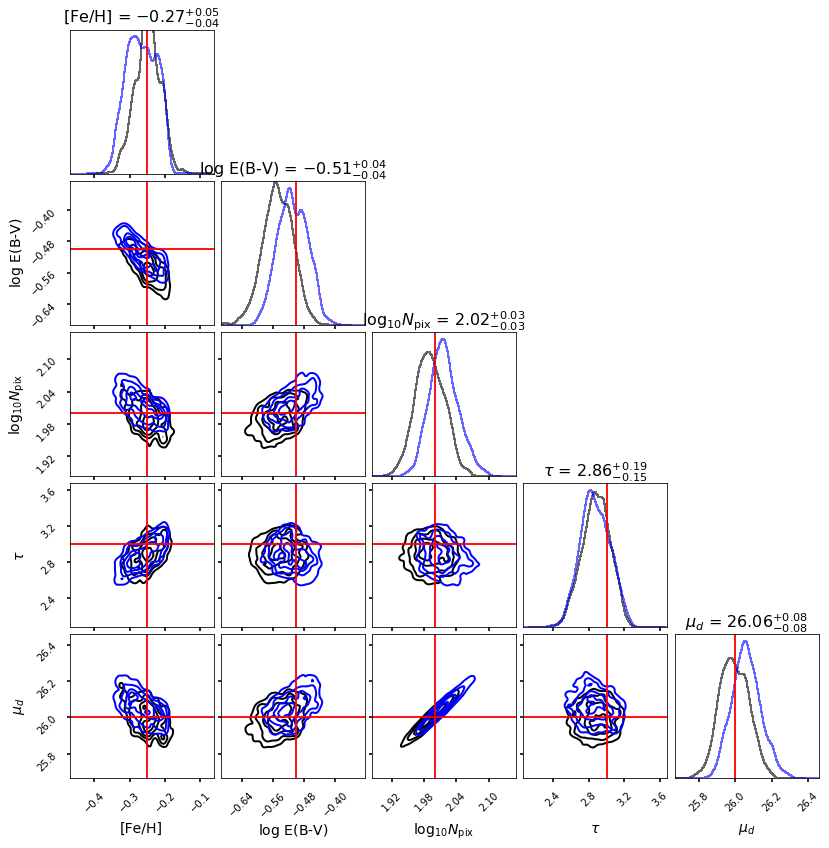

In [51]:
fig, axes = r.plot_corner(max_logl=logl_means['mock_5'], color='k', hist_kwargs={'histtype': 'step'},
                          quantiles=[], hist2d_kwargs={'fill_contours': False,
                                                          'plot_density': False,});
results['mock_18'].plot_corner(max_logl=logl_means['mock_18'], color='b', fig=(fig,axes),
                               hist_kwargs={'histtype': 'step'}, quantiles=[], hist2d_kwargs={'fill_contours': False,
                                                                                               'plot_density': False});

In [30]:
results['mock_5'].labels

['[Fe/H]',
 '$\\log$ E(B-V)',
 '$\\log_{10} N_\\mathrm{pix}$',
 '$\\tau$',
 '$\\mu_d$']